<p class='cooltitle' style="font-size:35px; text-align:center;" >Neuronal Models</p>
<br><br>

Hudgkin & Huxley's model (1952) seen in the previous chapter has a very high biological plausibility, it takes into account a lot of underlying phenomena. Unfortunately, this can be very complex at certain times and it is accompanied by a very high implementation cost (in TFLOPS). <br>
Putting aside that biologically realistic model, there are a lot of other neuronal models that try to simplify or simply not take into account neither the geometry of the neuron nor some of its underlying mechanisms.

In 1962, **Fitzugh and Nagumo** tried to introduce some simplifications to the 4 nonlinear differential equations systems in H&H model, reducing it to a 2 state variable system; keeping in tact the spike generation behavior after a stimulus and yet reducing the model complexity; although not being biologically as plausible as the H&H model.

Years later in 1983, and building upon the Fitzugh - Nagumo Model, **Hindmarsh and Rose** proposed a dynamical system of 3 coupled differential equations, accounting for the extra chaotic dynamics of membrane voltage while still being simpler than H&H model.

In this notebook, we're going to start with a simple introduction to qualitative approach of differential equations and dynamical systems by studying a unidimensional neuronal dynamical system **The $I_{Kir}$ model**, and then we can move on to simulating those 2 models : **The Fitzugh-Nagumo model** and **the Hindmarsh-Rose model**

<h1>Table of contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-uni-dimensional-$I_{Kir}$-model" data-toc-modified-id="The-uni-dimensional-$I_{Kir}$-model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The uni-dimensional $I_{Kir}$ model</a></span></li><li><span><a href="#The--Fitzugh-Nagumo-Model" data-toc-modified-id="The--Fitzugh-Nagumo-Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>The  Fitzugh-Nagumo Model</a></span></li><li><span><a href="#The-Hindmarsh-Rose-Model" data-toc-modified-id="The-Hindmarsh-Rose-Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>The Hindmarsh-Rose Model</a></span></li></ul></div>

Let's start by importing some libraries and functions that will serve our purpose.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
from scipy.optimize import bisect
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D

# The uni-dimensional $I_{Kir}$ model
 

- A uni-dimensional dynamical system like : 
$$\dot V = F(V)$$ 
<br>

> Describes how the rate of change $\frac{dV}{dt}$ depends on the variable $V$ itself, if $F(V) > 0$ increases, so does V and vice versa.

- The equilibrium of the system is the state of the system $V$ for which $F(V) = 0$, we consider the equilibrium to be stable when $F(V)$ changes the sign of $V$ so when $F'(V) < 0$, the equilibrium will be unstable when $F'(V) > 0$

- The phase portrait is a representation of the trajectories of the dynamical system in the phase plane.

- A bifurcation is considered a qualitative change in the phase portrait of the system (its equilibria).

- The inward rectifying potassium channel model $I_{Kir}$ is described as a uni-dimensional dynamical system : 

<br>

 $$\large{\color{red}{C\dot{V} = I - g_L(V - E_L) - g_{Kir}h_\infty(V)(V - E_K)}}$$ 

<br>
 $$\large{\color{red}{h_\infty(V) = \frac{1}{1 + e^{(\frac{V_{1/2} - V}{k})}}}}$$



> With the following given parameters :  



<table style="width:90%;border: 1px solid black; border-collapse: collapse;">
    <tr>
        <th style="text-align:center; border-right:1px solid black; background-color: black;
  color: white">$\bf{C}$</th>
        <th style="text-align:center; border-right:1px solid black;  background-color: black;
  color: white">$\bf{g_L}$</th>
        <th  style="text-align:center;  background-color: black;
  color: white ">$\bf{E_L}$</th>
        <th style="text-align:center; border-right:1px solid black; background-color: black;
  color: white">$\bf{g_K}$</th>
        <th style="text-align:center; border-right:1px solid black;  background-color: black;
  color: white">$\bf{E_K}$</th>
        <th  style="text-align:center;  background-color: black;
  color: white ">$\bf{V_{1/2}}$</th>
         <th  style="text-align:center;  background-color: black;
  color: white ">$\bf{k}$</th>
    </tr>
    <tr>
        <td style="text-align:center;border-right:1px solid black;border-bottom: 1px solid black">$\bf{1}$</td>
        <td style="text-align:center;border-right:1px solid black;border-bottom: 1px solid black">$\bf{0.2}$</td>
        <td style="text-align:center; border-right:1px solid black;border-bottom: 1px solid black">$\bf{-50}$</td>
        <td style="text-align:center;border-right:1px solid black;border-bottom: 1px solid black">$\bf{2}$</td>
        <td style="text-align:center;border-right:1px solid black;border-bottom: 1px solid black">$\bf{-80}$</td>
        <td style="text-align:center; border-right:1px solid black;border-bottom: 1px solid black">$\bf{-76}$</td>
        <td style="text-align:center;border-right:1px solid black;border-bottom: 1px solid black">$\bf{-12}$</td>                  
    </tr>
    </table>

**First off, let's take a look at the gating variable $h_\infty(V)$** and the **I-V** curves

> Declaring the given parameters : 

In [2]:
C ,g_L, E_L, g_K, E_K, V_half, k  = 1, 0.2, -50, 2, -80, -76, -12 

> Writing lambda functions to send back the gating variable and the currents of the model : 

In [3]:
h_infty = lambda voltage: 1 / (1 + np.exp((V_half - voltage) / k))

leak = lambda voltage: g_L * (voltage - E_L)

kir = lambda voltage: g_K * h_infty(voltage) * (voltage - E_K)

> And now let's take a look at how they change between -200 and +100 mV

Text(0.5, 0.98, '$I_{Kir}$ model')

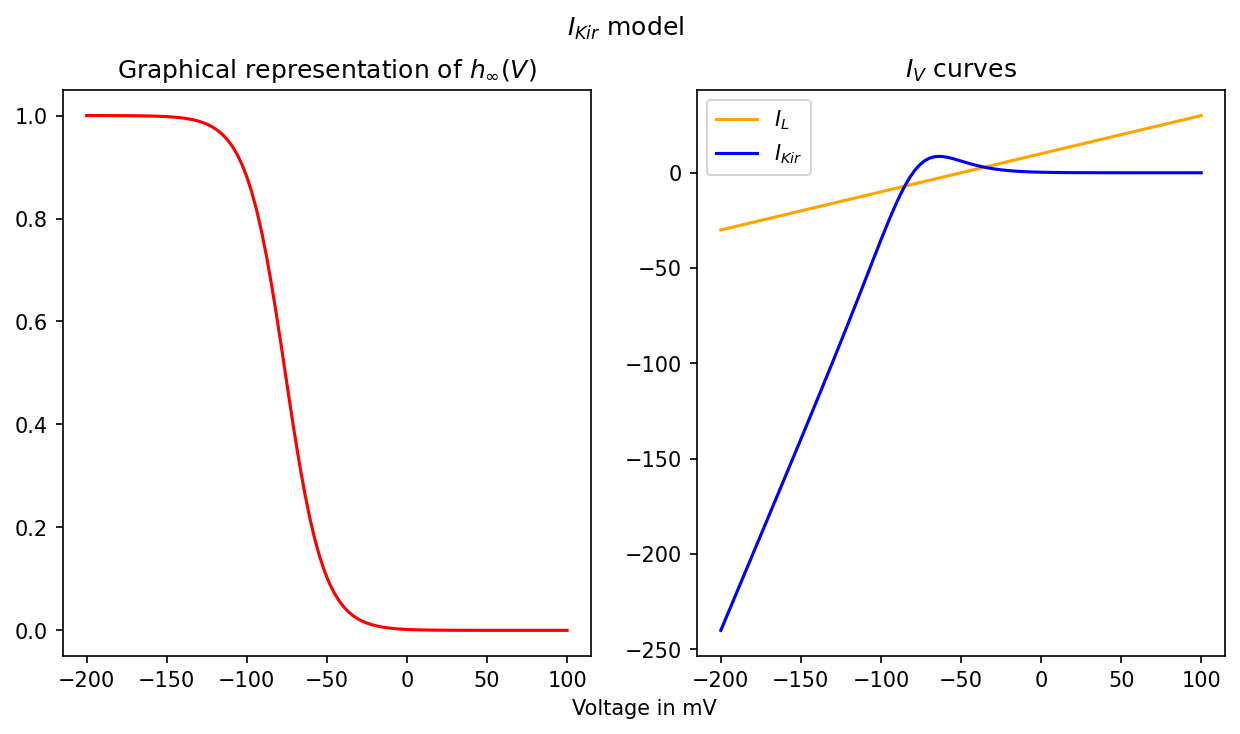

In [4]:
v = np.linspace(-200,100,100)
fig, ax = plt.subplots(1,2, figsize = (10,5), dpi = 150)
ax[0].plot(v, h_infty(v), 'r') #h_infty plot
ax[0].set_title("Graphical representation of $h_\infty(V)$")
ax[0].set_xlabel("Voltage in mV", position = (1.1,0))
ax[1].plot(v, leak(v), color = 'orange', label='$I_L$') #leak current
ax[1].plot(v, kir(v), 'b', label='$I_{Kir}$') #Kir current
ax[1].set_title("$I_V$ curves")
ax[1].legend()
plt.suptitle("$I_{Kir}$ model")

**Now let's take a look at the phase portrait while injecting a current $I = 6$**

> We can start by writing a function for $\frac{dv}{dt}$

In [8]:
iinj = 6
def V_dot(voltage, inject):
    return (inject - g_L * (voltage - E_L) - g_K * h_infty(voltage) *
            (voltage - E_K)) / C

> In order to find the equilibrium points for the system we must solve the equation while the derivative is 0.
<br>We can use a function from scipy module to find the root of our function for a certain interval. <br>
P.S : It might be interesting to plot our phase portrait before doing this step in order to approximate where our equlibrium points are.

In [29]:
eq1 = bisect(
    V_dot, -70, -60, iinj
)  # Solve it for an interval [-70,-60], iinj = 6 is the injected current
eq2 = bisect(V_dot, -50, -40, iinj)
eq3 = bisect(V_dot, -40, -20, iinj)

eq_points = [eq1, eq2, eq3]

> To determine the equilibrium type we must see the sign of the slope of $\frac{dv}{dt}$, if it was negative, then the equilibrium will be stable, otherwise it will be unstable

In [34]:
def eq_type(equilibrium, xdot, xdot_params):
    for eq in equilibrium:
        print('%s point is stable' %
              eq) if xdot(eq, xdot_params) < 0 else print('%s point is unstable' %
                                                          eq)


eq_type(eq_points, V_dot, iinj)

-62.986925364792796 point is stable
-46.87693559917193 point is unstable
-31.870204731864078 point is unstable


> So we have 1 stable equilbrium and 2 unstable equilibria, let's now see the phase portrait between -75 and -10 mV

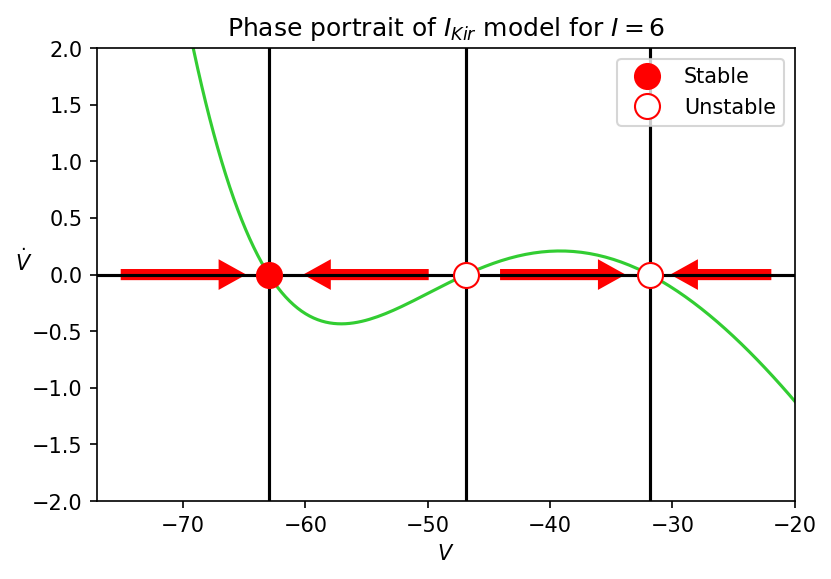

In [35]:
volt = np.linspace(-75, -10, 200)

# Phase portrait
plt.figure(dpi=150)
plt.plot(volt, V_dot(volt, iinj), color="limegreen")
plt.axhline(y=0, color='black')  # Horizontal line to see where dvdt = 0
for eq in eq_points:  # Three vertical lines that pass through equilibrium
    plt.axvline(x=eq, color='black')
# Equilibrium points
plt.plot(eq1, 0, 'ro', fillstyle='full', markersize=12, label="Stable")
plt.plot(eq3, 0, 'wo', markeredgecolor='red', markersize=12)
plt.plot(eq2, 0, 'wo', markeredgecolor='red', markersize=12, label="Unstable")
# Plotting to show stability
plt.arrow(-75, 0, dx=+8, dy=0, width=0.08, color='red', head_length=2)
plt.arrow(-50, 0, dx=-8, dy=0, width=0.08, color='red', head_length=2)
plt.arrow(-44, 0, dx=+8, dy=0, width=0.08, color='red', head_length=2)
plt.arrow(-22, 0, dx=-6, dy=0, width=0.08, color='red', head_length=2)
plt.ylim(-2, 2)
plt.xlim(-77, -20)
plt.title("Phase portrait of $I_{Kir}$ model for $I = 6$")
plt.xlabel("$V$")
plt.ylabel("$\dot{V}$", rotation=0)
plt.legend()

**Bifurcation diagram with $I$ as a bifurcation parameter**

> We only saw the phase portrait for $I=6$,  but we can consider $I$ as bifurcation parameter that'll qualitatively change the equilibria of the systems and induce a bifurcation. <br>
Now it would be interesting to see the eqilibria points of the system in function of the injected current $I$.<br>
While $\dot V = 0$, we can see that $I = I_{Kir} + I_L$


In [37]:
def injected(voltage):
    return leak(voltage) + kir(voltage)

> Now let's take a look at the bifurcation diagram

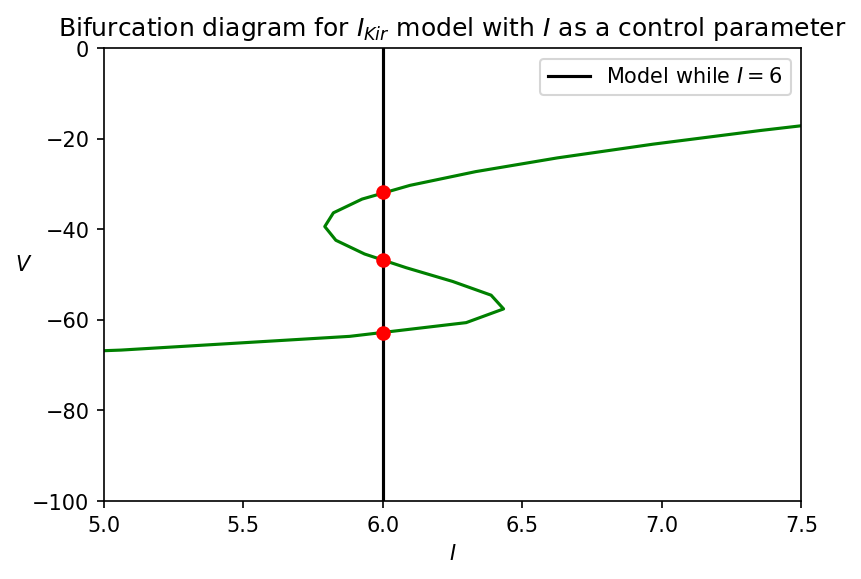

In [41]:
plt.figure(dpi=150)
plt.plot(injected(v), v, 'g')
plt.axvline(x=6, color='black',
            label="Model while $I=6$")  # See equilbria while I=6
plt.plot(iinj, eq1, 'ro', iinj, eq2, 'ro', iinj, eq3, 'ro')
plt.xlim(5, 7.5)
plt.ylim(-100, 0)
plt.xlabel("$I$")
plt.ylabel("$V$", rotation=0)
plt.title(
    "Bifurcation diagram for $I_{Kir}$ model with $I$ as a control parameter")
plt.legend()

<hr class="sep">

# The  Fitzugh-Nagumo Model
**Bi-dimensional dynamical systems**


- A bi-dimensional dynamical system of differential equations : 

>$$\dot{x} = f(x,y)\ ,\ \dot{x} = \frac{\delta{f}}{\delta{x}}x + \frac{\delta{f}}{\delta{y}}y $$ <br>
$$\dot{y} = g(x,y)\ , \ \dot{y} = \frac{\delta{g}}{\delta{x}}x + \frac{\delta{g}}{\delta{y}}y$$ <br>
will describe the evolution of our two state variables $x$ and $y$, at most cases, our two variables are the membrane voltage and the recovery variable.


- The group of points given by the equations $f(x,y) = 0$ and $g(x,y) = 0$ are the **$\bf{x-}$** and **$\bf{y-}$nullclines** respectively.

- The points of intersection of our nullclines are the equilibria of the system.
- An equilibrium is stable when the the neighbouring trajectories are attracted to it. 


**The Fitzhugh-Nagumo equations describe a bi-dimensional dynamical system :**
<br>
<br>
$$\large{\color{red}{\dot{v} = v - \frac{v^3}{3} - w + I}}$$
<br>
$$\large{\color{red}{\tau\dot{w} = v + a -b*w}}$$


> With the following parameters : 

<table style="width:30%;border: 1px solid black; border-collapse: collapse;">
    <tr>
        <th style="text-align:center; border-right:1px solid black; background-color: black;
  color: white">$\bf{a}$</th>
        <th style="text-align:center; border-right:1px solid black;  background-color: black;
  color: white">$\bf{b}$</th>
        <th  style="text-align:center;  background-color: black;
  color: white ">$\bf{\tau}$</th>
    </tr>
    <tr>
        <td style="text-align:center;border-right:1px solid black;border-bottom: 1px solid black">$\bf{0.7}$</td>
        <td style="text-align:center;border-right:1px solid black;border-bottom: 1px solid black">$\bf{0.8}$</td>
        <td style="text-align:center; border-right:1px solid black;border-bottom: 1px solid black">$\bf{13}$</td>               
    </tr>
    </table>



- At The equilibrium  $\bf{(v^\ast,w^\ast)}$, the derivatives will be zero : 
$$v - \frac{v^3}{3} - w + I= 0$$
$$v + a -b*w = 0$$
<br>

> which makes : $$w = v - \frac{v^3}{3} + I \ \ (V-nullcline)$$  <br>
$$w = \frac{(v + a)}{b} \ \  (w-nullcline)$$ 

<br>
$$\Rightarrow\boxed{v - \frac{v^3}{3} + I - \frac{(v + a)}{b} = 0}$$
<br>

> This is the equation to be solved if we wanted to find the equilibrium (the intersection of the nullclines), we can use either  NumPy or SymPy like we saw in other notebooks.


> Like always, let's start by declaring the model's parameters

In [3]:
a, b, tau = 0.7, 0.8, 13 # The parameters of the model

> Now let's implement the equation to be solved 

In [4]:
eq_equation = lambda v, I: v - (v**3 / 3) + I - ((v + a) / b)


def eq_coordinates(eq_equation, I):
    """This function sends back the equilibrium coordinates of The Fitzugh-Nagumo Model
    for the equilibrium equation specified as the eq_equation.
    """
    vstar = bisect(
        eq_equation, -2, +2, I
    )  #solve eq_equation between -2 and +2 with bisect function from scipy
    wstar = (vstar + a) / b
    return vstar, wstar

> Next step would be to implement our model's nullclines and equations

In [5]:
def vnull(v, I):
    "V-nullcline of the Fitzugh-Nagumo model"
    return v - v**3 / 3 + I


def wnull(v, a, b):
    "w-nullcline of the Fitzugh-Nagumo model"
    return (v + a) / b


def vdot(v, w, I):
    """this function sends back the values of dvdt"""
    return v - v**3 / 3 - w + I


def wdot(v, w):
    """this function sends back the values of dwdt"""
    return (v + a - b * w) / tau


def fitz_nagu(t, z, I):
    """This function contains the equations of the model,
    it will be used with scipy's solve_ivp function in order to solve the system
    numerically starting from initial conditions."""
    v, w = z
    return np.array([vdot(v, w, I), wdot(v, w)])

> Now the system of equations can be solved numerically like we did with Hugkin and Huxley's model with scipy's solve_ivp. <br>
It would be interesting to write a function that simulates the model for given initial conditions of $V$ , $w$ and $I$.


In [12]:
def simulate_fitz_nagu(V_init, w_init, I_init, Tmax):
    
    # Determining equilibrium 
    v_star, w_star = eq_coordinates(eq_equation,
                                  I=I_init)

    # Solve the system
    sol = solve_ivp(
        lambda t, z: fitz_nagu(t, z, I=I_init), [0, Tmax],
        (V_init, w_init
         ), t_eval=np.linspace(0, Tmax, 150))  # An anonymous function with fitz-nagu was used because solve_ip
    # doesn't suppport specifiying other parameters for the function to be
    # solved, this can be a work-around as it lets us specify I

    tt, vt, wt = sol.t, sol.y[0], sol.y[
        1]  # Time, voltage and recovery variable

    # Voltage and arrows
    volt = np.linspace(-5, 5, 100)  # Voltage array between -5 and +5 mV
    x_arrs, y_arrs = np.meshgrid(np.linspace(-3, +3, 15),
                                 np.linspace(-2, +2, 10))

    # Figure and axes
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=150)
    cam = Camera(fig)
    # Animation
    for i in range(len(tt)):
        s1, = axes[0].plot(vt[:i], wt[:i], 'r')
        ng1, = axes[0].plot(volt, vnull(volt, I=I_init), color="orange")
        ng2, = axes[0].plot(volt, wnull(volt, a, b), 'b')
        eq, = axes[0].plot(v_star, w_star, 'ko', label="Stable Node")
        axes[0].quiver(x_arrs,y_arrs,vdot(x_arrs,y_arrs,I_init),wdot(\
                            x_arrs,y_arrs), color = 'green')
        axes[0].legend(
            [ng1, ng2, eq, s1],
            ['$V$-nullcline', '$w$-nullcline', 'Equilibrium', 'Solution'])
        axes[0].set_ylim(-2, +2)
        axes[0].set_xlim(-3, 3)
        axes[0].set_ylabel('$w$', rotation=0)
        axes[0].set_xlabel('$V$')
        axes[0].set_title('Phase portrait')

        vg, = axes[1].plot(tt[:i], vt[:i], color='orange')
        wg, = axes[1].plot(tt[:i], wt[:i], 'b')
        axes[1].legend([vg, wg], ['$V(t)$', '$w(t)$'])
        axes[1].set_xlabel('Time')
        axes[1].set_title('Numerical solution')
        fig.suptitle(
            "Fitzugh and Nagumo model Simulation, Initial conditions : $V$ = %s, $w$ = %s, $I$ = %s"
            % (V_init, w_init, I_init))
        cam.snap()
    cam.animate(blit=False, interval=30,
                    repeat=True).save('fitz_nagu.mp4')

> Let's take a look at the system while $I = 0.3$ and with the initial conditions are : $V =0, w=0$

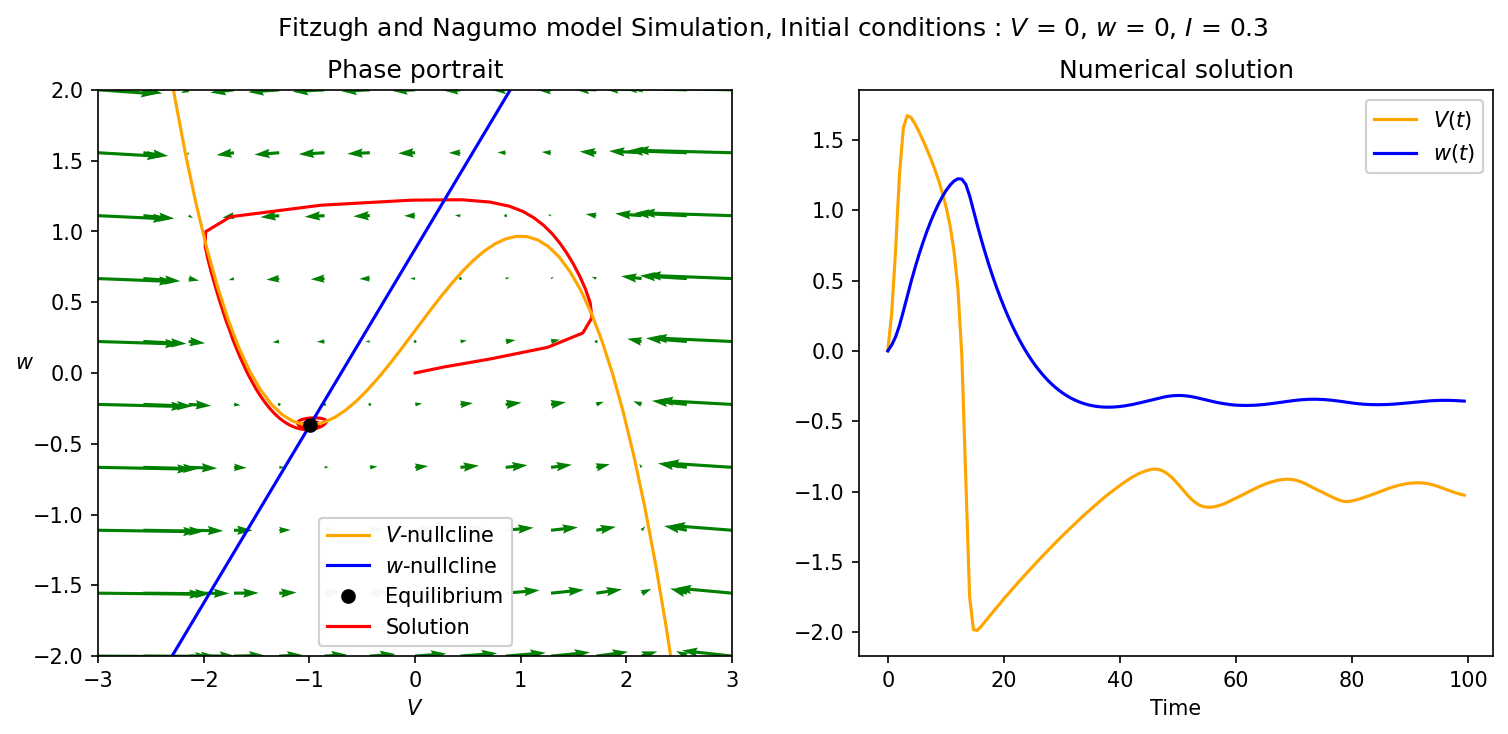

In [11]:
simulate_fitz_nagu(V_init=0,w_init=0, I_init=0.3, Tmax=100)

> Another simulation with : $V =-2, w=-1.5, I = 0.5$

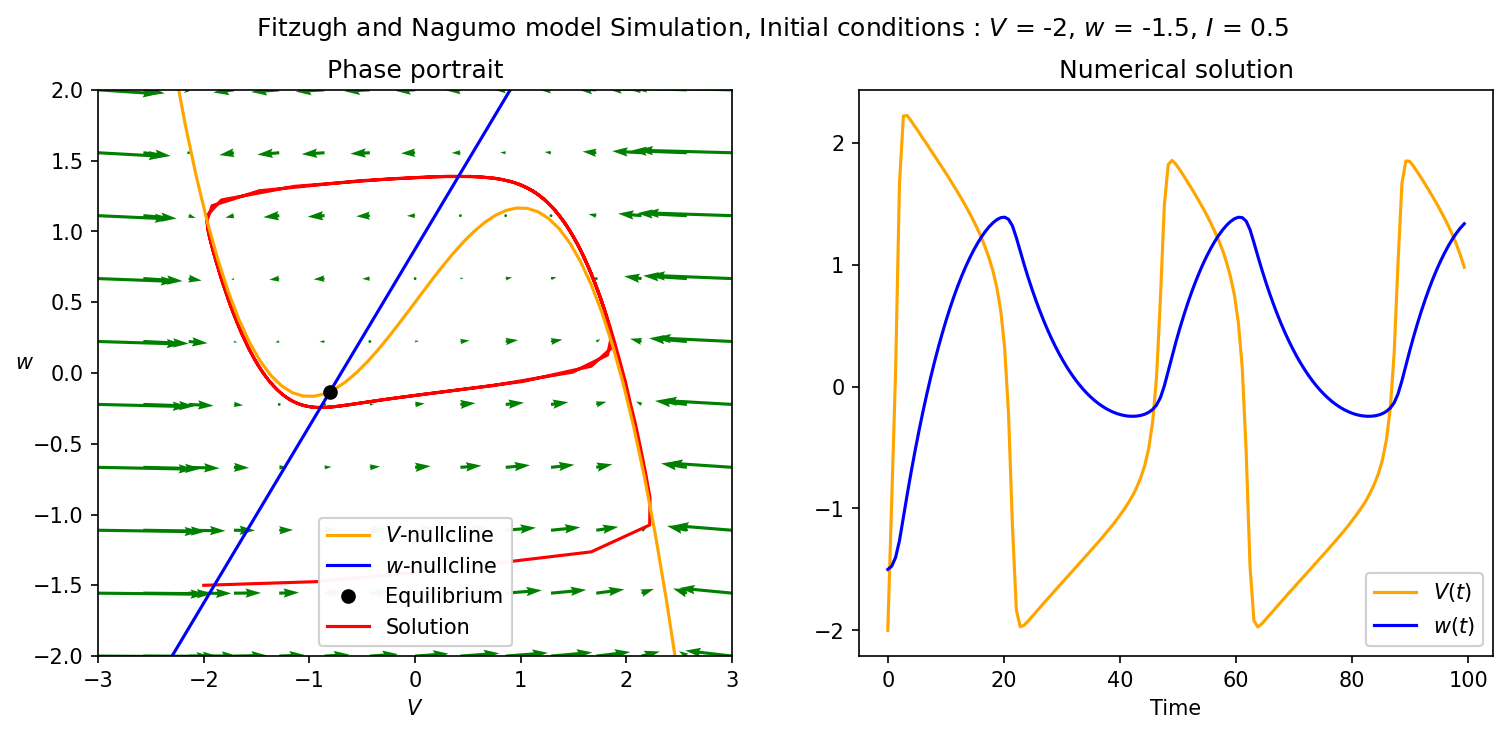

In [10]:
simulate_fitz_nagu(V_init=-2,w_init=-1.5, I_init=0.5, Tmax=100)

<hr class="sep">

# The Hindmarsh-Rose Model
<br>

- This model was made to account for the bursting activity of certain neurons, it is made of 3 dimensionless state variables : 

> $x(t)$ The membrane potential <br>
$y(t)$ which represents the spiking variable or the fast sodium and potassium currents<br>
$z(t)$ is the bursting variable, it represents the slow ionic currents.<br>

- The Model is expressed by the following equations : 

$$\large{\color {red} {\dot x = y + \phi(x) - z + I}}$$
$$\large{\color {red} {\dot y = \psi(x) - y}}$$
$$\large{\color {red} {\dot z = r(s(x - x_r)-z)}}$$
<br><br>

> with : 
<br>
$$\large{\color {red} {\phi(x) = -ax^3 + bx^2}}$$
$$\large{\color {red} {\psi(x) = c - dx^2}}$$
<br>
> And The parameters are :  
<table style="width:90%;border: 1px solid black; border-collapse: collapse;">
    <tr>
        <th style="text-align:center; border-right:1px solid black; background-color: black;
  color: white">$\bf{s}$</th>
        <th style="text-align:center; border-right:1px solid black;  background-color: black;
  color: white">$\bf{x_r}$</th>
        <th  style="text-align:center;  background-color: black;
  color: white ">$\bf{a}$</th>
        <th style="text-align:center; border-right:1px solid black; background-color: black;
  color: white">$\bf{b}$</th>
        <th style="text-align:center; border-right:1px solid black;  background-color: black;
  color: white">$\bf{c}$</th>
        <th  style="text-align:center;  background-color: black;
  color: white ">$\bf{d}$</th>
         <th  style="text-align:center;  background-color: black;
  color: white ">$\bf{I}$</th>
          <th  style="text-align:center;  background-color: black;
  color: white ">$\bf{r}$</th>
    </tr>
    <tr>
        <td style="text-align:center;border-right:1px solid black;border-bottom: 1px solid black">$\bf{4}$</td>
        <td style="text-align:center;border-right:1px solid black;border-bottom: 1px solid black">$\bf{\frac{-8}{5}}$</td>
        <td style="text-align:center; border-right:1px solid black;border-bottom: 1px solid black">$\bf{1}$</td>
        <td style="text-align:center;border-right:1px solid black;border-bottom: 1px solid black">$\bf{3}$</td>
        <td style="text-align:center;border-right:1px solid black;border-bottom: 1px solid black">$\bf{1}$</td>
        <td style="text-align:center;border-right:1px solid black;border-bottom: 1px solid black">$\bf{5}$</td>
        <td style="text-align:center; border-right:1px solid black;border-bottom: 1px solid black">$\bf{[-10,10]}$</td>
        <td style="text-align:center;border-right:1px solid black;border-bottom: 1px solid black">$\bf{10^{-3}}$</td>                  
    </tr>
    </table>


**Let's do a numerical simulation of the system while using r as a bifurcation parameter**

> In order to be able to change the values of r (or any other parameter) while solving the system, we can write a wrapper function around the equations function (that returns it); and then we can pass the wrapper function to solve_ivp.

In [2]:
def hind_rose(r , s = 4, xr = -8/5, a = 1, b = 3, c = 1, d = 5, I = 2) :
    """
    Hindmarsh-Rose system (x,y,z)
    r : bifurcation parameter 
    """
    def pre_hind_rose(t, vars) : 
    
        x, y, z = vars
        return np.array([y - a*x**3 + b*x**2 - z + I,\
                         c - d*x**2 - y,\
                         r *(s*(x - xr) - z)])
    return pre_hind_rose

> Now we're going to write a function to simulate this model from chosen initial conditions, this function will be written while using r as a bifurcation parameter but it can be easily modified for it to suit the use of other parameters as control.

In [9]:
def simulate_hind_rose(x_init, y_init, z_init, r_param, Tmax):

    # First off, let's solve the system from our initial conditions and our chose r value
    sol = solve_ivp(hind_rose(r=r_param), [0, Tmax], (x_init, y_init, z_init), t_eval=np.linspace(0, Tmax, 500))

    # Let's separate the solutions and the time vector
    tt, tx, ty, tz = sol.t, sol.y[0], sol.y[1], sol.y[2]

    # And now let's create the animation
    fig = plt.figure(figsize=(12, 5), dpi=150)
    cam = Camera(fig)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122, projection='3d')
    for i in range(len(tt)):
        ax1.plot(tt[:i], tx[:i], 'r')
        ax1.set_xlabel('t')
        ax1.set_ylabel('$x$', rotation=0)
        ax2.plot(tx[:i], ty[:i], tz[:i], 'b')
        ax2.set_zlabel('$z$')
        ax2.set_xlabel('$x$')
        ax2.set_ylabel('$y$')
        ax2.set_zlim(1.6,2.2)
        fig.suptitle(
            "Hindmarsh and Rose model Simulation, Initial conditions : $x$ = %s, $y$ = %s, $z$ = %s, $r$=%s"
            % (x_init, y_init, z_init, r_param))
        cam.snap()
    cam.animate(blit=False, interval=40, repeat=True).save('HR.mp4')

> Let's now simulate the model with $r=0.001$ and $x=-1.5, y=-10, z=2$

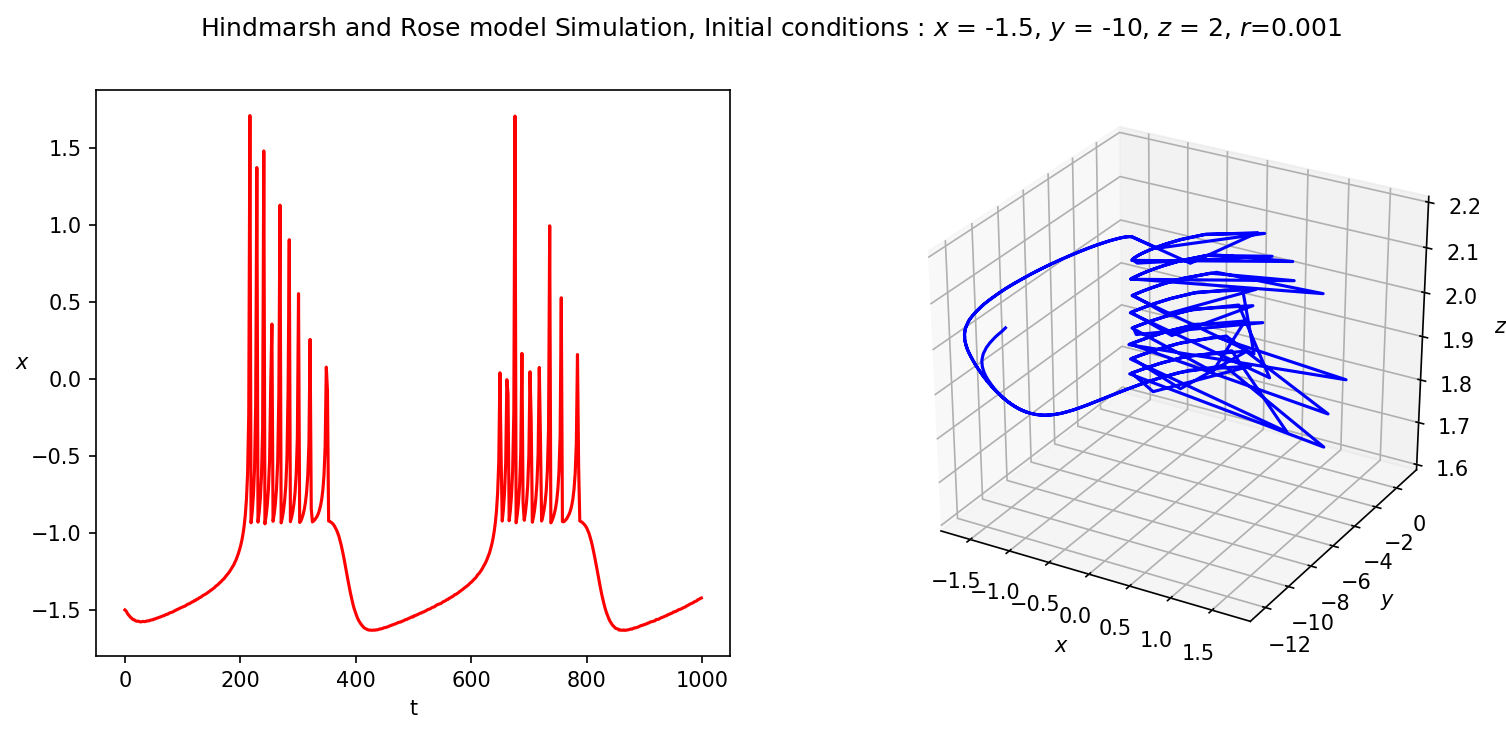

In [10]:
simulate_hind_rose(x_init=-1.5, y_init=-10, z_init=2, r_param=0.001, Tmax=1000)

<hr class="sep">